In [2]:
# Importing libraries for Data Processing
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image, ImageEnhance

In [4]:

# Importing libraries for ML Models
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras.models import *
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.preprocessing.image import load_img

In [5]:
# Importing libraries for Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os
import random


In [6]:

#reading the data from training and testing directories we have in dataset

train_dir = '/kaggle/input/brain-tumor-mri-dataset/Training/'
test_dir = '/kaggle/input/brain-tumor-mri-dataset/Testing/'

train_paths = []
train_labels = []

for label in os.listdir(train_dir):
    for image in os.listdir(train_dir+label):
        train_paths.append(train_dir+label+'/'+image)
        train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)

test_paths = []
test_labels = []

for label in os.listdir(test_dir):
    for image in os.listdir(test_dir+label):
        test_paths.append(test_dir+label+'/'+image)
        test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)

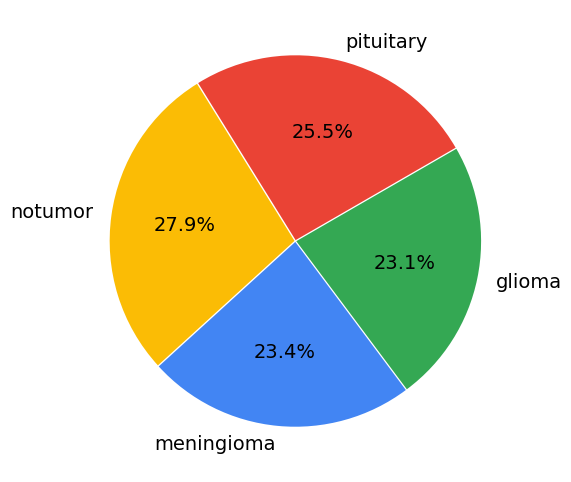

In [7]:
#code to plot the 4 labels (types of tumors) we have in the dataset 

plt.figure(figsize=(14,6))
colors = ['#ea4335', '#fbbc05', '#4285f3', '#34a853']
plt.rcParams.update({'font.size': 14})
plt.pie([len([x for x in train_labels if x=='pituitary']),
         len([x for x in train_labels if x=='notumor']),
         len([x for x in train_labels if x=='meningioma']),
         len([x for x in train_labels if x=='glioma'])],
        labels=['pituitary','notumor', 'meningioma', 'glioma'],
        colors=colors, autopct='%.1f%%', explode=(0.005,0.005,0.005,0.005),
        startangle=30);

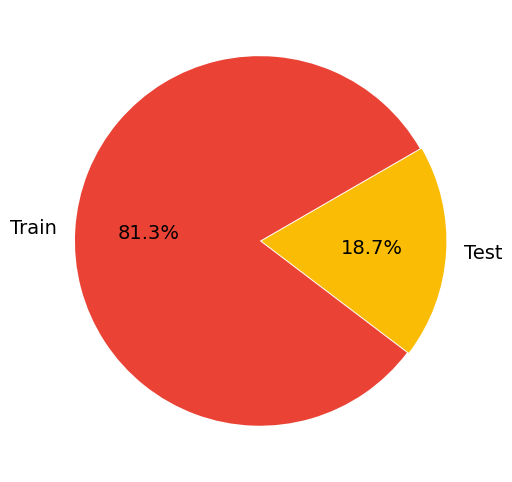

In [8]:
plt.figure(figsize=(14,6))
colors = [ '#ea4335','#fbbc05']
plt.rcParams.update({'font.size': 14})
plt.pie([len(train_labels), len(test_labels)],
        labels=['Train','Test'],
        colors=colors, autopct='%.1f%%', explode=(0.005,0.005),
        startangle=30);

In [10]:
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8,1.2))
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8,1.2))
    image = np.array(image)/255.0
    return image

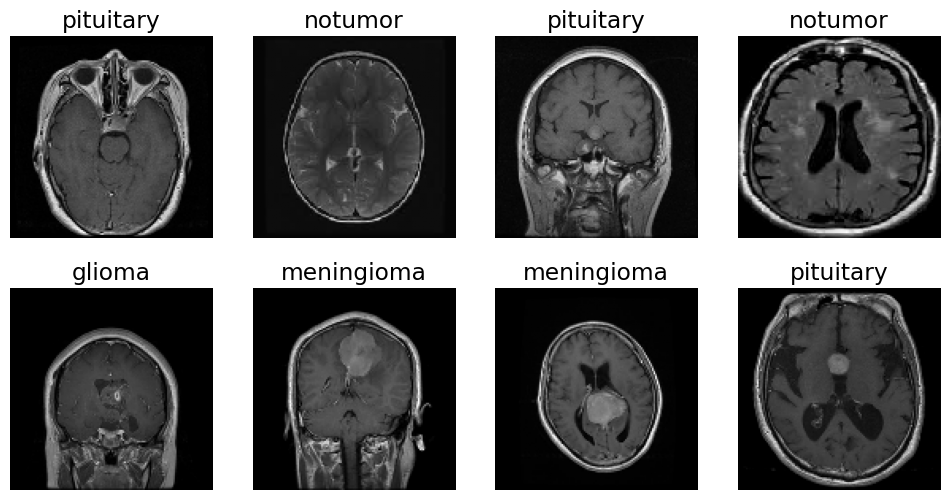

In [11]:
IMAGE_SIZE = 128

#function to display images for reference

def open_images(paths):
    '''
    Given a list of paths to images, this function returns the images as arrays (after augmenting them)
    '''
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE,IMAGE_SIZE))
        image = augment_image(image)
        images.append(image)
    return np.array(images)

images = open_images(train_paths[50:59])
labels = train_labels[50:59]
fig = plt.figure(figsize=(12, 6))
for x in range(1, 9):
    fig.add_subplot(2, 4, x)
    plt.axis('off')
    plt.title(labels[x])
    plt.imshow(images[x])
plt.rcParams.update({'font.size': 12})
plt.show()

In [12]:
#assiging labels we have in the training directory of our dataset
unique_labels = os.listdir(train_dir)

#functions to encode & decode the labels and return the images so that the model can train on the same 
def encode_label(labels):
    encoded = []
    for x in labels:
        encoded.append(unique_labels.index(x))
    return np.array(encoded)

def decode_label(labels):
    decoded = []
    for x in labels:
        decoded.append(unique_labels[x])
    return np.array(decoded)


In [13]:
def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for x in range(0, len(paths), batch_size):
            batch_paths = paths[x:x+batch_size]
            batch_images = open_images(batch_paths)
            batch_labels = labels[x:x+batch_size]
            batch_labels = encode_label(batch_labels)
            yield batch_images, batch_labels


In [14]:

#We have used VGG16 model for transfer learning. Froze the top layers by setting the include_top to false and added few other layers to enhance the performance
base_model = VGG16(input_shape=(IMAGE_SIZE,IMAGE_SIZE,3), include_top=False, weights='imagenet')
# Set all layers to non-trainable
for layer in base_model.layers:
    layer.trainable = False


model = Sequential()
model.add(Input(shape=(IMAGE_SIZE,IMAGE_SIZE,3)))
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(len(unique_labels), activation='softmax'))
model.summary()

58889256/58889256 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dropout (Dropout)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 4)                 32772     
                                                                 
Total params: 14,747,460
Trainable params: 32,772
Non-trainable params: 14,714,688
_________________________________________________________________


In [15]:
model.compile(optimizer=Adam(learning_rate=0.01),loss='sparse_categorical_crossentropy',
             metrics=['sparse_categorical_accuracy'])


In [16]:
batch_size = 32
steps = int(len(train_paths)/batch_size)
epochs = 15
history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)

Epoch 1/15
178/178 [==============================] - 459s 3s/step - loss: 1.0878 - sparse_categorical_accuracy: 0.7956
Epoch 2/15
178/178 [==============================] - 458s 3s/step - loss: 0.6209 - sparse_categorical_accuracy: 0.8590
Epoch 3/15
178/178 [==============================] - 457s 3s/step - loss: 0.5321 - sparse_categorical_accuracy: 0.8813
Epoch 4/15
178/178 [==============================] - 457s 3s/step - loss: 0.5905 - sparse_categorical_accuracy: 0.8850
Epoch 5/15
178/178 [==============================] - 457s 3s/step - loss: 0.5165 - sparse_categorical_accuracy: 0.9000
Epoch 6/15
178/178 [==============================] - 457s 3s/step - loss: 0.4658 - sparse_categorical_accuracy: 0.9125
Epoch 7/15
178/178 [==============================] - 458s 3s/step - loss: 0.5242 - sparse_categorical_accuracy: 0.9019
Epoch 8/15
178/178 [==============================] - 458s 3s/step - loss: 0.5078 - sparse_categorical_accuracy: 0.9134
Epoch 9/15
178/178 [====================

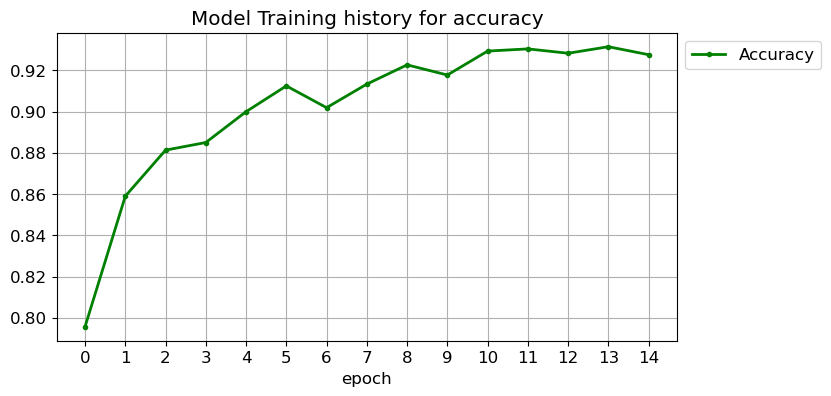

In [17]:
#code to plot graph for accuracy and loss
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth=2)
plt.title('Model Training history for accuracy')
plt.xlabel('epoch')
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy'], loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

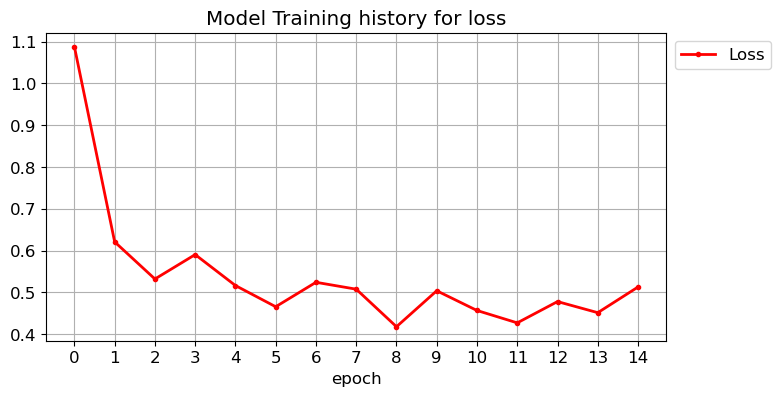

In [18]:
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history.history['loss'], '.r-', linewidth=2)
plt.title('Model Training history for loss')
plt.xlabel('epoch')
plt.xticks([x for x in range(epochs)])
plt.legend(['Loss'], loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [19]:
#decoding the same and appending them to y_pred and y_true
#y_pred is predicted and y_true is ground truth
batch_size = 32
steps = int(len(test_paths)/batch_size)
y_pred = []
y_true = []
for x,y in tqdm(datagen(test_paths, test_labels, batch_size=batch_size, epochs=1), total=steps):
    pred = model.predict(x)
    pred = np.argmax(pred, axis=-1)
    for i in decode_label(pred):
        y_pred.append(i)
    for i in decode_label(y):
        y_true.append(i)

  0%|          | 0/40 [00:00<?, ?it/s]

1/1 [==============================] - 3s 3s/step


  2%|▎         | 1/40 [00:03<02:07,  3.27s/it]

1/1 [==============================] - 3s 3s/step


  5%|▌         | 2/40 [00:06<01:58,  3.11s/it]

1/1 [==============================] - 3s 3s/step


  8%|▊         | 3/40 [00:09<01:52,  3.04s/it]

1/1 [==============================] - 3s 3s/step


 10%|█         | 4/40 [00:12<01:46,  2.95s/it]

1/1 [==============================] - 3s 3s/step


 12%|█▎        | 5/40 [00:14<01:42,  2.92s/it]

1/1 [==============================] - 3s 3s/step


 15%|█▌        | 6/40 [00:17<01:38,  2.89s/it]

1/1 [==============================] - 3s 3s/step


 18%|█▊        | 7/40 [00:20<01:34,  2.87s/it]

1/1 [==============================] - 3s 3s/step


 20%|██        | 8/40 [00:23<01:32,  2.88s/it]

1/1 [==============================] - 3s 3s/step


 22%|██▎       | 9/40 [00:26<01:29,  2.87s/it]

1/1 [==============================] - 3s 3s/step


 25%|██▌       | 10/40 [00:29<01:26,  2.87s/it]

1/1 [==============================] - 3s 3s/step


 28%|██▊       | 11/40 [00:32<01:22,  2.86s/it]

1/1 [==============================] - 3s 3s/step


 30%|███       | 12/40 [00:34<01:20,  2.88s/it]

1/1 [==============================] - 3s 3s/step


 32%|███▎      | 13/40 [00:37<01:17,  2.86s/it]

1/1 [==============================] - 3s 3s/step


 35%|███▌      | 14/40 [00:40<01:16,  2.93s/it]

1/1 [==============================] - 3s 3s/step


 38%|███▊      | 15/40 [00:43<01:12,  2.91s/it]

1/1 [==============================] - 3s 3s/step


 40%|████      | 16/40 [00:46<01:09,  2.90s/it]

1/1 [==============================] - 3s 3s/step


 42%|████▎     | 17/40 [00:49<01:06,  2.88s/it]

1/1 [==============================] - 3s 3s/step


 45%|████▌     | 18/40 [00:52<01:03,  2.87s/it]

1/1 [==============================] - 3s 3s/step


 48%|████▊     | 19/40 [00:55<01:00,  2.86s/it]

1/1 [==============================] - 3s 3s/step


 50%|█████     | 20/40 [00:57<00:57,  2.87s/it]

1/1 [==============================] - 3s 3s/step


 52%|█████▎    | 21/40 [01:00<00:54,  2.85s/it]

1/1 [==============================] - 3s 3s/step


 55%|█████▌    | 22/40 [01:03<00:51,  2.86s/it]

1/1 [==============================] - 3s 3s/step


 57%|█████▊    | 23/40 [01:06<00:48,  2.85s/it]

1/1 [==============================] - 3s 3s/step


 60%|██████    | 24/40 [01:09<00:45,  2.84s/it]

1/1 [==============================] - 3s 3s/step


 62%|██████▎   | 25/40 [01:12<00:44,  2.96s/it]

1/1 [==============================] - 3s 3s/step


 65%|██████▌   | 26/40 [01:15<00:40,  2.91s/it]

1/1 [==============================] - 3s 3s/step


 68%|██████▊   | 27/40 [01:18<00:37,  2.87s/it]

1/1 [==============================] - 3s 3s/step


 70%|███████   | 28/40 [01:20<00:34,  2.85s/it]

1/1 [==============================] - 3s 3s/step


 72%|███████▎  | 29/40 [01:23<00:31,  2.84s/it]

1/1 [==============================] - 3s 3s/step


 75%|███████▌  | 30/40 [01:26<00:28,  2.85s/it]

1/1 [==============================] - 3s 3s/step


 78%|███████▊  | 31/40 [01:29<00:25,  2.83s/it]

1/1 [==============================] - 3s 3s/step


 80%|████████  | 32/40 [01:32<00:22,  2.83s/it]

1/1 [==============================] - 3s 3s/step


 82%|████████▎ | 33/40 [01:35<00:19,  2.84s/it]

1/1 [==============================] - 3s 3s/step


 85%|████████▌ | 34/40 [01:37<00:17,  2.85s/it]

1/1 [==============================] - 3s 3s/step


 88%|████████▊ | 35/40 [01:40<00:14,  2.84s/it]

1/1 [==============================] - 3s 3s/step


 90%|█████████ | 36/40 [01:44<00:11,  2.96s/it]

1/1 [==============================] - 3s 3s/step


 92%|█████████▎| 37/40 [01:46<00:08,  2.93s/it]

1/1 [==============================] - 3s 3s/step


 95%|█████████▌| 38/40 [01:49<00:05,  2.90s/it]

1/1 [==============================] - 3s 3s/step


 98%|█████████▊| 39/40 [01:52<00:02,  2.88s/it]

1/1 [==============================] - 3s 3s/step


100%|██████████| 40/40 [01:55<00:00,  2.85s/it]

1/1 [==============================] - 3s 3s/step


41it [01:58,  2.88s/it]                        


In [20]:
#below is the get the report for predictions and ground truth
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

      glioma       0.96      0.68      0.80       300
  meningioma       0.61      0.98      0.75       306
     notumor       0.99      0.99      0.99       405
   pituitary       1.00      0.68      0.81       300

    accuracy                           0.85      1311
   macro avg       0.89      0.83      0.84      1311
weighted avg       0.90      0.85      0.85      1311



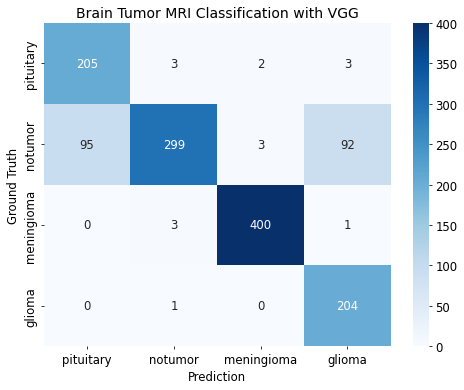

In [21]:
labels=['pituitary','notumor', 'meningioma', 'glioma']
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import scikitplot as skplt

cnf = confusion_matrix(y_pred, y_true)
plt.figure(figsize=(8,6), dpi=70, facecolor='w', edgecolor='k')
ax = sns.heatmap(cnf, cmap='Blues', annot=True, fmt = 'd', xticklabels=labels, yticklabels=labels)
plt.title('Brain Tumor MRI Classification with VGG')
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.show(ax)